# Data streaming

## Task 1. Sampling

Group 97

Estimate the distribution over the other IP-address, what are the 10 most frequent values? Write code for RESERVOIR sampling, using it to estimate the distribution in one pass (no need to actually stream the data, you may store it in memeory, or run every file separately, but do store and load the intermediate results). Use a range of reservoir sizes. What are the 10 most frequent IP-addresses and their frequencies when sampled? Use the theory to explain any approximation errors you observe.

Reference: "An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

In [1]:
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)
%matplotlib inline

Here we use scenario 2 (CTU-Malware-Capture-Botnet-42) for the task. 

Per the documentaion for the dataset, the number of differnt types of flow on this scenario is:

| Total flows | Botnet flows | Normal flows | C&C flows | Background flows |
|-------------|--------------|--------------|-----------|------------------|
| 2,824,636   | 1.41%        | 1.07%        | 0.03%     | 97.47%           |

The infected IP address is ***147.32.84.165***.

In [2]:
# define filepath for scenario 1 dataset
filepath = './data/capture20110811.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing(data):
    '''data preprocessing
    Input
    -----
    string of a data flow
    
    Return
    ------
    ip_address and label
    '''
    s = data.split('\t')
    s = [x for x in s if x] # remove empty elements
    # modify data type
    o = np.array([s[3].split(':')[0], #ScrAddr
                  s[5].split(':')[0], #DstAddr
                  s[11].rstrip('\n').rstrip() #Label
                 ])
    return o

## Reservoir sampling

In [4]:
print('The total number of stream data is {}.'.format(len(data)))

The total number of stream data is 6351188.


In [5]:
INFECTED_HOST = '147.32.84.165'

def reservoir_sampling(k=60000, full_df=False):
    '''sampling through a reservoir of size k
    Parameter
    ---------
    k : reservoir size
    
    Return
    ------
    top10 : the top 10 most frequent infected ip_address and freq count
    pp : proportion of reservoir size to stream size
    exe_time : execution time of reservoir sampling
    '''
    START = time.time()
    
    reservoir = list(map(preprocessing, data[:k]))
    for i in range(k+1, len(data)):
        # for pi, randomly replace j-th data in the reservoir with i-th data
        if np.random.random() < k/i: # probability pi=k/i
            j = int(np.random.randint(0, k, 1))
            reservoir[j] = preprocessing(data[i])
    df = pd.DataFrame(reservoir, columns=['ScrAddr', 'DstAddr', 'Label'])
    
    # get the top10 most frequent ip and their frequencies
    ips = df.loc[df['Label'] == 'Botnet']
    infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
    infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
    count = np.unique(infected_ips, return_counts=True)
    count = pd.DataFrame({'ip' : count[0],
                          'freq' : count[1]})
    if not full_df: # return top 10 most frequent
        top10 = count.sort_values('freq', ascending=False).head(10)
    else: # return all df
        top10 = count.sort_values('freq', ascending=False)
    pp = np.round(k/len(data), 3) # proportion of reservoir size to stream size
    
    END = time.time()
    return top10, pp, END - START

### Different reservoir sizes

#### 1. Reservoir size = 6,350 (or 0.001 * stream size)

===== reservoir sampling time: 2.53 sec =====


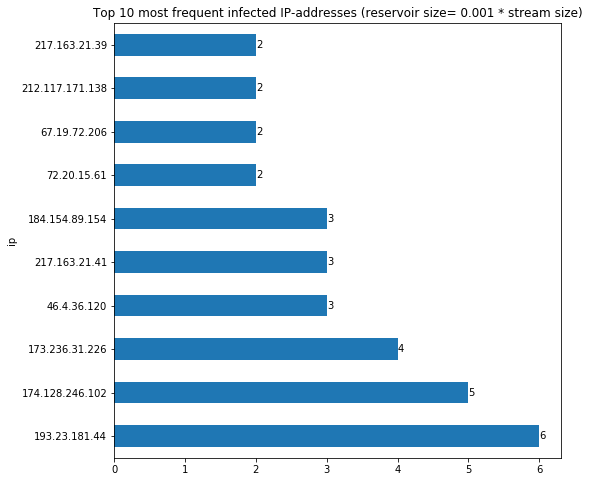

In [6]:
ips, pp, exe_time = reservoir_sampling(6350) # reservior size = 6350
print('===== reservoir sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent infected IP-addresses (reservoir size= %0.3f * stream size)' % pp)


# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = ips.copy()
exe_times = np.array([exe_time])

#### 2. Reservoir size = 63,500 (or 0.01 * stream size)

===== reservoir sampling time: 4.06 sec =====


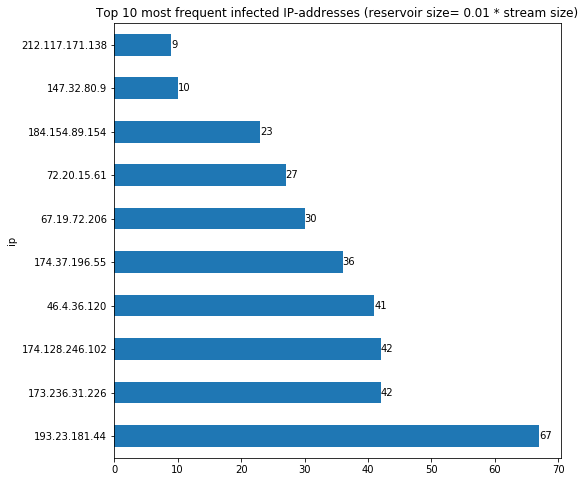

In [7]:
ips, pp, exe_time = reservoir_sampling(63500) # reservior size = 63,500
print('===== reservoir sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent infected IP-addresses (reservoir size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

#### 3. Reservoir size = 635,000 (or 0.1 * stream size)

===== reservoir sampling time: 12.86 sec =====


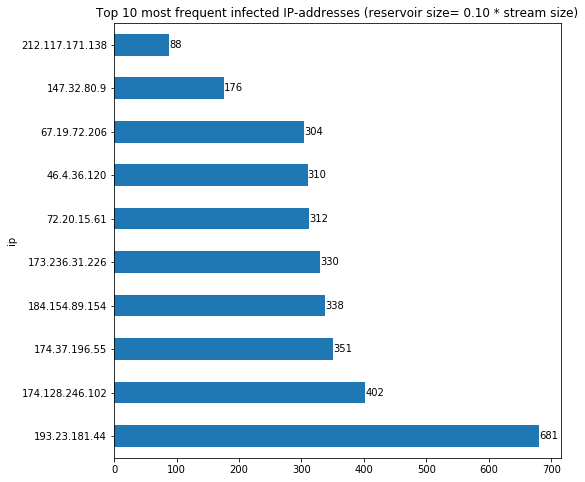

In [8]:
ips, pp, exe_time = reservoir_sampling(635000) # reservior size = 635,000
print('===== reservoir sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent infected IP-addresses (reservoir size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

#### 4. Reservoir size = 1,270,000 (or 0.2 * stream size)

===== reservoir sampling time: 18.84 sec =====


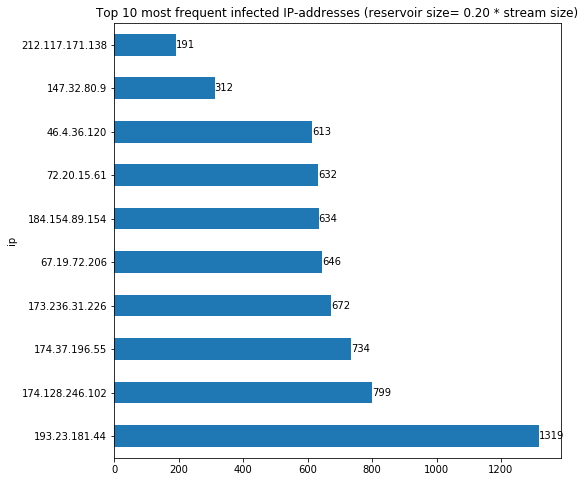

In [9]:
ips, pp, exe_time = reservoir_sampling(1270000) # reservoir size = 1,270,000
print('===== reservoir sampling time: {0:0.2f} sec ====='.format(exe_time))

ax = ips.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8),
              title='Top 10 most frequent infected IP-addresses (reservoir size= %0.2f * stream size)' % (pp))

# add freq values to the barplot
for i, v in enumerate(ips.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips.freq = ips.freq.apply(lambda x: x/pp)
ips_top10 = pd.merge(ips_top10, ips, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

## Reference: the real ranking

We calculate the results for the full stream data for comparison.

In [10]:
START = time.time()
df = pd.DataFrame(list(map(preprocessing, data)), 
                  columns=['ScrAddr', 'DstAddr', 'Label'])
ips = df.loc[df['Label'] == 'Botnet']
infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
count = np.unique(infected_ips, return_counts=True)
count = pd.DataFrame({'ip' : count[0],
                      'freq' : count[1]})
top10 = count.sort_values('freq', ascending=False).head(10)
exe_time = time.time() - START

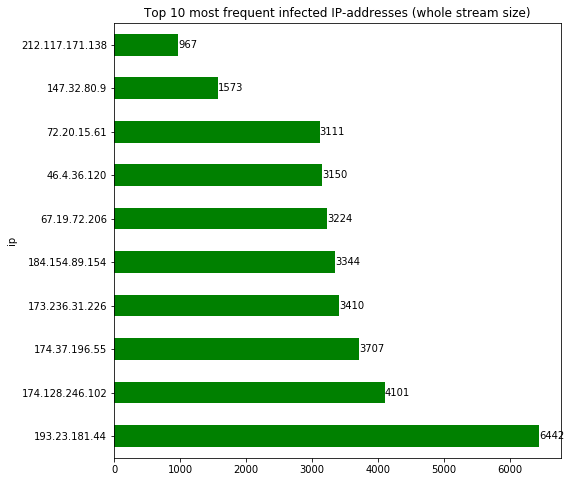

In [11]:
ax = top10.plot(x='ip', y='freq', kind='barh', legend=False, figsize=(8,8), color='g',
                title='Top 10 most frequent infected IP-addresses (whole stream size)')

# add freq values to the barplot
for i, v in enumerate(top10.values):
    ax.text(v[1], i, str(v[1]), va='center')

# book keeping
ips_top10 = pd.merge(ips_top10, top10, how='outer', on='ip')
exe_times = np.append(exe_times, exe_time)

## Comparison

Compare the results of different reservoir sizes and of raw stream.

In [12]:
ips_top10.fillna(value=0, inplace=True)
ips_top10.set_index('ip', inplace=True)
ips_top10.columns = ['.001', '.01', '.1', '.2', 'stream']

In [13]:
ips_top10 # show the results of different reservoir sizes

,.001,.01,.1,.2,stream
ip,,,,,
193.23.181.44,6000.0,6700.0,6810.0,6595.0,6442.0
174.128.246.102,5000.0,4200.0,4020.0,3995.0,4101.0
173.236.31.226,4000.0,4200.0,3300.0,3360.0,3410.0
46.4.36.120,3000.0,4100.0,3100.0,3065.0,3150.0
217.163.21.41,3000.0,0.0,0.0,0.0,0.0
184.154.89.154,3000.0,2300.0,3380.0,3170.0,3344.0
72.20.15.61,2000.0,2700.0,3120.0,3160.0,3111.0
67.19.72.206,2000.0,3000.0,3040.0,3230.0,3224.0
212.117.171.138,2000.0,900.0,880.0,955.0,967.0


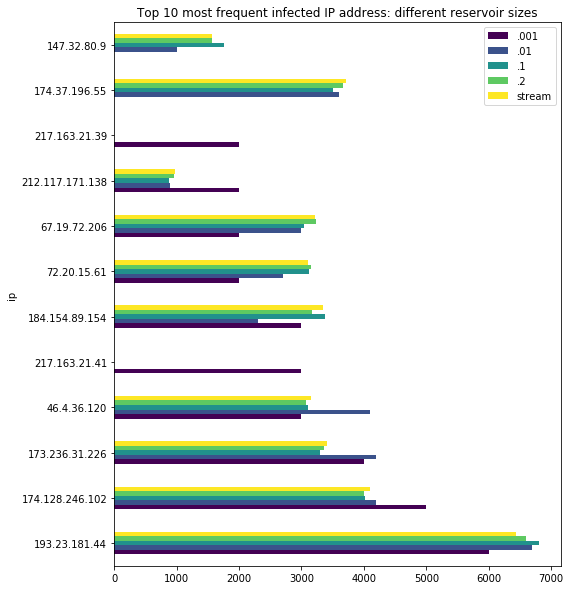

In [14]:
ips_top10.plot(kind='barh', figsize=(8, 10), colormap='viridis',
               title='Top 10 most frequent infected IP address: different reservoir sizes')

Text(0, 0.5, 'Run time (sec)')

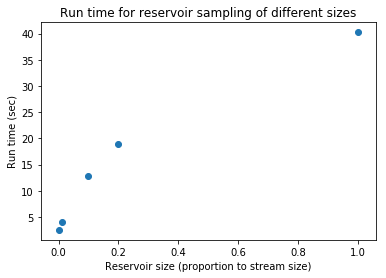

In [15]:
plt.scatter([float(x) for x in ips_top10.columns[:-1]]+[1], exe_times)
plt.title('Run time for reservoir sampling of different sizes')
plt.xlabel('Reservoir size (proportion to stream size)')
plt.ylabel('Run time (sec)')

## Distribution over the other IP-address using reservoir sampling

Here we calculate the distribution using reservoir sampling of size of 0.01 * stream size. We compare it with the "real" distribution of the full stream data.

Text(0.5, 1.0, 'Distribution of frequencies of infected IP address using reservoir sampling')

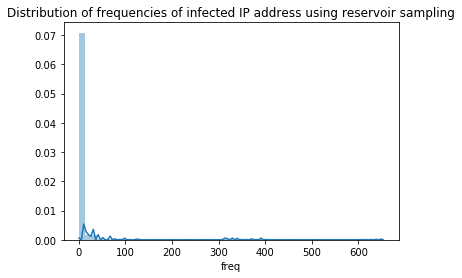

In [16]:
ips, pp, _ = reservoir_sampling(635000, full_df=True) # reservoir size = 0.01*stream size

# plot the distribution of ip address frequencies
fig, ax = plt.subplots()
sns.distplot(ips.freq, ax=ax)
ax.set_title('Distribution of frequencies of infected IP address using reservoir sampling')

Text(0.5, 1.0, 'Distribution of frequencies of infected IP address - full stream')

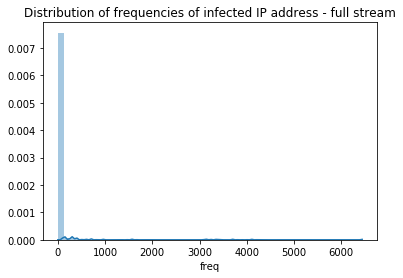

In [17]:
ips_all = count.sort_values('freq', ascending=False)

# plot the distribution of ip address frequencies
fig, ax = plt.subplots()
sns.distplot(ips_all.freq, ax=ax)
ax.set_title('Distribution of frequencies of infected IP address - full stream')